In [ ]:
# Import Necessary Libraries
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import glob
import json
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch import optim
from tqdm.auto import tqdm
from transformers import get_cosine_schedule_with_warmup
import cv2
import random
import torchvision.transforms.functional as TF
import pickle
import random

In [ ]:
train_folder = '/content/drive/MyDrive/Training folder/train/'
test_folder = '/content/drive/MyDrive/Training folder/test/'
valid_folder = '/content/drive/MyDrive/Training folder/valid/'

In [ ]:
train_images=[os.path.join(train_folder, image) for image in os.listdir(train_folder)]
test_images=[os.path.join(test_folder, image) for image in os.listdir(test_folder)]
valid_images=[os.path.join(valid_folder, image) for image in os.listdir(valid_folder)]

In [ ]:
train_annotation=glob.glob(os.path.join(train_folder,"*.json"))
test_annotation=glob.glob(os.path.join(test_folder,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_folder,"*.json"))

In [ ]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

In [ ]:
class TumorDataset(Dataset):
    def __init__(self, data_dict, train=True, image_size=128, random_crop_ratio=(0.5, 1)):
        self.data = data_dict
        self.train = train
        self.image_size = image_size
        self.min_ratio, self.max_ratio = random_crop_ratio

        self.resize = transforms.Resize(size=(self.image_size, self.image_size))
        self.random_resize = transforms.RandomResizedCrop(size=(self.image_size, self.image_size))
        self.horizontal_flip = transforms.RandomHorizontalFlip(p=1)
        self.totensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        jpg = self.data[idx][0]
        segmentation = self.data[idx][1]
        image = Image.open(jpg)


        mask = np.zeros((image.size[0], image.size[1]), dtype=np.uint8)
        points = np.array(segmentation).reshape(-1, 2)

        if points.size > 0:
            cv2.fillPoly(mask, [points.astype(np.int32)], 1)
        mask = Image.fromarray(mask)

        if self.train:

            ### Resize Image and Mask ###
            if random.random() < 0.5:

                image = self.resize(image)
                mask = self.resize(mask)

            ### Random Resized Crop ###
            else:

                ### Get Smaller Side ###
                min_side = min(image.size)

                ### Get a Random Crop Size with Ratio ###
                random_ratio = random.uniform(self.min_ratio, self.max_ratio)

                ### Compute Crop Size ###
                crop_size = int(random_ratio * min_side)

                ### Get Parameters of Random Crop ###
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))

                ### Crop Image and Annotation ###
                image = TF.crop(image, i, j, h, w)
                mask = TF.crop(mask, i, j, h, w)

                ### Resize Image to Desired Image Size ###
                image = self.resize(image)
                mask = self.resize(mask)


            ### Random Horizontal Flip ###
            if random.random() < 0.5:
                image = self.horizontal_flip(image)
                mask = self.horizontal_flip(mask)

        ### Validation Image Transforms ###
        else:

            image = self.resize(image)
            mask = self.resize(mask)

        ### Convert Everything to Tensors ###

        image = self.totensor(image)
        mask = torch.tensor(np.array(mask), dtype=torch.float).unsqueeze(0)

        ### Normalize Image ###
        normalizing_transform = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        image = normalizing_transform(image)

        return image, mask

In [ ]:
train = (train_images, train_annotation)
test = (test_images, test_annotation)
valid = (valid_images, valid_annotation)

In [ ]:
images = train_annotation['images']
annotations = train_annotation['annotations']

In [ ]:
def build_data_dict(images, annotations, root):
    image_id_dict = {}
    for image in images:
        # Label Images
        image_id_dict[image['id']] = image['file_name']
    data_dict = []
    for annotation in annotations:
        # Label Annotations
        annotation_id = annotation['image_id']
        jpg = os.path.join(root, image_id_dict[annotation_id])
        segmentation = annotation['segmentation'][0]
        data_dict.append((jpg, segmentation))
    return data_dict
train_data_dict = build_data_dict(train_annotation['images'], train_annotation['annotations'], train_folder)
test_data_dict = build_data_dict(test_annotation['images'], test_annotation['annotations'], test_folder)
valid_data_dict = build_data_dict(valid_annotation['images'], valid_annotation['annotations'], valid_folder)

print(len(train_data_dict))
print(len(test_data_dict))
print(len(valid_data_dict))

1502
215
429


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groupnorm_num_groups):
        super().__init__()

        ### Input Convolutions + GroupNorm ###
        self.groupnorm_1 = nn.GroupNorm(groupnorm_num_groups, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")

        ### Input + Time Embedding Convolutions + GroupNorm ###
        self.groupnorm_2 = nn.GroupNorm(groupnorm_num_groups, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")

        ### Residual Layer ###
        self.residual_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):

        ### Store Copy for Residual ###
        residual_connection = x

        ### Input GroupNorm and Convolutions ###
        x = self.groupnorm_1(x)
        x = F.relu(x)
        x = self.conv_1(x)

        ### Input Again ###
        x = self.groupnorm_2(x)
        x = F.relu(x)
        x = self.conv_2(x)

        ### Add Residual and Return ###
        x = x + self.residual_connection(residual_connection)

        return x

In [ ]:
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=2, padding=1)

### Transpose Convolutional Upsample by 2 ###
tconv = nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=2, stride=2)

### Random Tensor with spatial size 64 x 64 ###
rand_tensor = torch.randn(2,3,63,63)

### Pass Tensor through Convolutions ###
conv_out = conv(rand_tensor)
print("Convolution Output Shape:", conv_out.shape)
tconv_out = tconv(conv_out)
print("Transpose Convolution Output Shape:", tconv_out.shape)

Convolution Output Shape: torch.Size([2, 3, 32, 32])
Transpose Convolution Output Shape: torch.Size([2, 3, 64, 64])


In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, interpolate=False):
        super().__init__()

        if interpolate:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
            )

        else:
            self.upsample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        upsampled = self.upsample(inputs)
        assert (upsampled.shape == (batch, channels, height*2, width*2))
        return upsampled

In [ ]:
class UNET(nn.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=150,
                 start_dim=64,
                 dim_mults=(1,2,4,8),
                 residual_blocks_per_group=1,
                 groupnorm_num_groups=16,
                 skip_connection=True,
                 interpolated_upsample=False):

        super().__init__()
        self.skip_connection = skip_connection
        self.input_image_channels = in_channels
        self.interpolate = interpolated_upsample

        #######################################
        ### COMPUTE ALL OF THE CONVOLUTIONS ###
        #######################################

        ### Get Number of Channels at Each Block ###
        channel_sizes = [start_dim*i for i in dim_mults]
        starting_channel_size, ending_channel_size = channel_sizes[0], channel_sizes[-1]

        ### Compute the Input/Output Channel Sizes for Every Convolution of Encoder ###
        self.encoder_config = []

        for idx, d in enumerate(channel_sizes):
            ### For Every Channel Size add "residual_blocks_per_group" number of Residual Blocks that DONT Change the number of channels ###
            for _ in range(residual_blocks_per_group):
                self.encoder_config.append(((d, d), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height x Width)

            ### After Residual Blocks include Downsampling (by factor of 2) but dont change number of channels ###
            self.encoder_config.append(((d,d), "downsample")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels x Height/2 x Width/2)

            ### If we are not at the last channel size include a channel upsample (typically by factor of 2) ###
            if idx < len(channel_sizes) - 1:
                self.encoder_config.append(((d,channel_sizes[idx+1]), "residual")) # Shape: (Batch x Channels x Height x Width) -> (Batch x Channels*2 x Height x Width)

        ### The Bottleneck will have "residual_blocks_per_group" number of ResidualBlocks each with the input/output of our final channel size###
        self.bottleneck_config = []
        for _ in range(residual_blocks_per_group):
            self.bottleneck_config.append(((ending_channel_size, ending_channel_size), "residual"))

        ### Store a variable of the final Output Shape of our Encoder + Bottleneck so we can compute Decoder Shapes ###
        out_dim = ending_channel_size

        ### Reverse our Encoder config to compute the Decoder ###
        reversed_encoder_config = self.encoder_config[::-1]

        ### The output of our reversed encoder will be the number of channels added for residual connections ###
        self.decoder_config = []
        for idx, (metadata, type) in enumerate(reversed_encoder_config):
            ### Flip in_channels, out_channels with the previous out_dim added on ###
            enc_in_channels, enc_out_channels = metadata

            ### Compute Number of Input Channels (if we want concatenated skip connection or not) ###
            concat_num_channels = out_dim + enc_out_channels
            self.decoder_config.append(((concat_num_channels, enc_in_channels), "residual"))

            if type == "downsample":
                ### If we did a downsample in our encoder, we need to upsample in our decoder ###
                self.decoder_config.append(((enc_in_channels, enc_in_channels), "upsample"))

            ### The new out_dim will be the number of output channels from our block (or the cooresponding encoder input channels) ###
            out_dim = enc_in_channels

        ### Add Extra Residual Block for residual from input convolution ###
        # hint: We know that the initial convolution will have starting_channel_size
        # and the output of our decoder will also have starting_channel_size, so the
        # final ResidualBlock we need will need to go from starting_channel_size*2 to starting_channel_size

        concat_num_channels = starting_channel_size*2
        self.decoder_config.append(((concat_num_channels, starting_channel_size), "residual"))


        #######################################
        ### ACTUALLY BUILD THE CONVOLUTIONS ###
        #######################################

        ### Intial Convolution Block ###
        self.conv_in_proj = nn.Conv2d(self.input_image_channels,
                                      starting_channel_size,
                                      kernel_size=3,
                                      padding="same")

        self.encoder = nn.ModuleList()
        for metadata, type in self.encoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.encoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups))
            elif type == "downsample":
                in_channels, out_channels = metadata
                self.encoder.append(
                    nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=3,
                              stride=2,
                              padding=1)
                    )


        ### Build Encoder Blocks ###
        self.bottleneck = nn.ModuleList()

        for (in_channels, out_channels), _ in self.bottleneck_config:
            self.bottleneck.append(ResidualBlock(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 groupnorm_num_groups=groupnorm_num_groups))

        ### Build Decoder Blocks ###
        self.decoder = nn.ModuleList()
        for metadata, type in self.decoder_config:
            if type == "residual":
                in_channels, out_channels = metadata
                self.decoder.append(ResidualBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  groupnorm_num_groups=groupnorm_num_groups))
            elif type == "upsample":
                in_channels, out_channels = metadata
                self.decoder.append(UpsampleBlock(in_channels=in_channels,
                                                  out_channels=out_channels,
                                                  interpolate=self.interpolate))

        ### Output Convolution ###
        self.conv_out_proj = nn.Conv2d(in_channels=starting_channel_size,
                                       out_channels=num_classes,
                                       kernel_size=3,
                                       padding="same")


    def forward(self, x):
        residuals = []

        ### Pass Through Projection and Store Residual ###
        x = self.conv_in_proj(x)
        residuals.append(x)

        ### Pass through encoder and store residuals ##
        for module in self.encoder:
            x = module(x)
            residuals.append(x)


        ### Pass Through BottleNeck ###
        for module in self.bottleneck:
            x = module(x)

        ### Pass through Decoder while Concatenating Residuals ###
        for module in self.decoder:

            if isinstance(module, ResidualBlock):

                ### Pass through Convs with Skip Connections ###
                residual_tensor = residuals.pop()
                x  = torch.cat([x, residual_tensor], axis=1)
                x = module(x)

            else:
                ### Pass Through Upsample Block ###
                x = module(x)


        ### Map back to num_channels for final output ###
        x = self.conv_out_proj(x)

        return x

model = UNET(skip_connection=True)
rand = torch.randn(4,3,256,256)
model(rand).shape

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

44983446

In [ ]:
def train(skip_connection=True,
          learning_rate=0.001,
          batch_size=32,
          gradient_accumulation_steps=4,
          epochs=1,
          image_size=256,
          experiment_name="train",
          device="cuda"):
    ### Load AMP Scaler ###
    scaler = GradScaler()

    ### Dataset Dependent Settings ###
    NUM_CLASSES = 1

    ### Create Working Directory ###
    path_to_experiment = os.path.join(test_folder, experiment_name)
    if not os.path.exists(path_to_experiment):
        os.mkdir(path_to_experiment)

    path_to_model_save = os.path.join(path_to_experiment, experiment_name+".bin")
    path_to_logging_save = os.path.join(path_to_experiment, experiment_name+"_log.pkl")

    ### Set Training Device ###
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))
    ### Define Model ###
    model = UNET(skip_connection=skip_connection,
                 num_classes=NUM_CLASSES)

    model = model.to(device)

    ### Build DataLoaders ###
    micro_batchsize = batch_size // gradient_accumulation_steps
    train_data = TumorDataset(train_data_dict, train=True, image_size=image_size)
    test_data = TumorDataset(test_data_dict, train=False, image_size=image_size)
    train_dataloader = DataLoader(train_data, batch_size=micro_batchsize, shuffle=True, num_workers=2, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=micro_batchsize, shuffle=False, num_workers=2, pin_memory=True)

    ### Define Optimizer ###
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    ### Define Scheduler ###
    total_training_steps = int(epochs*len(train_dataloader) / gradient_accumulation_steps)
    print(f"Training for {total_training_steps} Steps")
    scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer,
                                                num_warmup_steps=int(0.1*total_training_steps),
                                                num_training_steps=total_training_steps)

    ### Train Log ###
    training_log = {"train_losses": [],
                    "train_accuracies": [],
                    "test_losses": [],
                    "test_accuracies": []}

    best_test_loss = np.inf

    for epoch in range(1, epochs + 1):
        print("EPOCH: [{}/{}]".format(epoch, epochs))
        train_loss = []
        train_acc = []
        test_loss = []
        test_acc = []

        ### Model Training ###
        model.train()
        loop_train = tqdm(train_dataloader, total=len(train_dataloader), leave=True)

        gradient_accum_iter = 0
        for idx, (img, trgt) in enumerate(loop_train):

            with torch.autocast(device_type="cuda" if torch.cuda.is_available() else "cpu", dtype=torch.bfloat16):

                ### Move Tensors to Device ###
                img, trgt = img.to(device), trgt.to(device)

                ### Pass Images through Model ###
                forward_out = model(img)



                ### Compute CrossEntropy Loss ###
                train_loss_val = loss_func(forward_out, trgt)

                ### Scale Loss by Gradient Accumulation Steps ###
                train_loss_val = train_loss_val / gradient_accumulation_steps

            ### Store Loss ###
            train_loss.append(train_loss_val.item()*gradient_accumulation_steps)

            ### Compute the Gradients ###
            scaler.scale(train_loss_val).backward()

            # Threshold forward_out for predictions #
            predicted = torch.sigmoid(forward_out)
            predicted = (predicted > 0.5).int()

            ### Compute Accuracy ###
            accuracy = (predicted == trgt).sum() / torch.numel(predicted)
            train_acc.append(accuracy.item())

            ### Iterate the Accumulation Counter ###
            gradient_accum_iter += 1

            if gradient_accum_iter % gradient_accumulation_steps == 0:

                ### Unscale Gradients for Clipping ###
                scaler.unscale_(optimizer)

                ### Clip Gradients ###
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                ### Update Model and Scheduler ###
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

        ### MODEL EVALUATION ###
        model.eval()
        loop_test = tqdm(test_dataloader, total=len(test_dataloader), leave=True)
        with torch.no_grad():
            for idx, (img, trgt) in enumerate(loop_test):
                img, trgt = img.to(device), trgt.to(device)
                forward_out = model(img)

                #forward_out = forward_out
                predicted = torch.sigmoid(forward_out)
                predicted = (predicted > 0.5).int()


                ### Compute CrossEntropy Loss ###
                test_loss_val = loss_func(forward_out, trgt)
                test_loss.append(test_loss_val.item())

                ### Compute Accuracy ###
                accuracy = (predicted == trgt).sum() / torch.numel(predicted)
                test_acc.append(accuracy.item())

        ### Compute Average Performance for Epoch ###
        avg_train_loss, avg_test_loss = np.mean(train_loss), np.mean(test_loss)
        avg_train_acc, avg_test_acc = np.mean(train_acc), np.mean(test_acc)

        if avg_test_loss < best_test_loss:
            print("**SAVING**")
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), path_to_model_save)

        print("Training Loss:", avg_train_loss)
        print("Training Acc:", avg_train_acc)
        print("Validation Loss:", avg_test_loss)
        print("Validation Acc:", avg_test_acc)

        training_log["train_losses"].append(avg_train_loss)
        training_log["train_accuracies"].append(avg_train_acc)
        training_log["test_losses"].append(avg_test_loss)
        training_log["test_accuracies"].append(avg_test_acc)

        ### Save Training Log ###
        with open(path_to_logging_save, 'wb') as handle:
            pickle.dump(training_log, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, training_log

model, training_log = train(epochs=50, experiment_name="UNET_tumor")


<ipython-input-67-263c37eb6e42>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training for 2350 Steps
EPOCH: [1/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.5821628112425196
Training Acc: 0.9007742423960503
Validation Loss: 0.33085547387599945
Validation Acc: 0.9160813137337014
EPOCH: [2/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.4622410811642383
Training Acc: 0.9043228746728694
Validation Loss: 0.3205975713553252
Validation Acc: 0.9103478855556912
EPOCH: [3/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.443188987038237
Training Acc: 0.9112809905980496
Validation Loss: 0.3308391024669011
Validation Acc: 0.9440387354956733
EPOCH: [4/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.43329836285494744
Training Acc: 0.9164468855299848
Validation Loss: 0.2920921853295079
Validation Acc: 0.9261571809097573
EPOCH: [5/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.37087670840481496
Training Acc: 0.9191365546368538
Validation Loss: 0.24238659220713157
Validation Acc: 0.9479581559145892
EPOCH: [6/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.36859557967870793
Training Acc: 0.9200217099265849
Validation Loss: 0.2717579636308882
Validation Acc: 0.9185929784068355
EPOCH: [7/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.35762910901549017
Training Acc: 0.92048915903619
Validation Loss: 0.25048545830779606
Validation Acc: 0.9169666369756063
EPOCH: [8/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.34158930436093754
Training Acc: 0.9230695144927248
Validation Loss: 0.23132234811782837
Validation Acc: 0.9415342145495944
EPOCH: [9/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.34063383025374816
Training Acc: 0.9227215958402512
Validation Loss: 0.2743203463377776
Validation Acc: 0.9404092122007299
EPOCH: [10/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.3315401853240551
Training Acc: 0.9253704126210923
Validation Loss: 0.23837086779099922
Validation Acc: 0.9517722968701963
EPOCH: [11/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.31207918740333396
Training Acc: 0.9261218537675574
Validation Loss: 0.20995626460622857
Validation Acc: 0.9452373473732559
EPOCH: [12/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.28844458047062793
Training Acc: 0.9297374699344026
Validation Loss: 0.21198294008219684
Validation Acc: 0.9443919680736683
EPOCH: [13/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.30581353359082913
Training Acc: 0.9299130408053703
Validation Loss: 0.21798241138458252
Validation Acc: 0.9495465137340404
EPOCH: [14/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.29606086380304175
Training Acc: 0.9322041216048789
Validation Loss: 0.1932023807808205
Validation Acc: 0.9444885673346343
EPOCH: [15/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.274872842621296
Training Acc: 0.9347121867727726
Validation Loss: 0.18904028805317702
Validation Acc: 0.9648313191201952
EPOCH: [16/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.26535713736047134
Training Acc: 0.9377815977055975
Validation Loss: 0.18920978903770447
Validation Acc: 0.9499647175824201
EPOCH: [17/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.26294093535460056
Training Acc: 0.9376823344129197
Validation Loss: 0.18254817911872157
Validation Acc: 0.947394730868163
EPOCH: [18/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.2662108573824801
Training Acc: 0.9362430033531595
Validation Loss: 0.19008417648297768
Validation Acc: 0.9495026844519155
EPOCH: [19/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.2528713810792629
Training Acc: 0.9368417212303649
Validation Loss: 0.18707450562053257
Validation Acc: 0.9522303850562485
EPOCH: [20/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.24711020318593116
Training Acc: 0.9405451531105853
Validation Loss: 0.16903748915151315
Validation Acc: 0.9569728109571669
EPOCH: [21/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.24311801636631183
Training Acc: 0.9411042161444401
Validation Loss: 0.16298977616760466
Validation Acc: 0.9654771023326449
EPOCH: [22/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.23897314432295078
Training Acc: 0.9396124190472542
Validation Loss: 0.17277956119290105
Validation Acc: 0.9533767214527836
EPOCH: [23/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.23963855829169142
Training Acc: 0.941525878741386
Validation Loss: 0.17004521991367694
Validation Acc: 0.960542740645232
EPOCH: [24/50]


  0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf5d00d6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf5d00d6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.23076002870468384
Training Acc: 0.9440301396745316
Validation Loss: 0.16827186555774123
Validation Acc: 0.9450303448571099
EPOCH: [25/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.2239613578199072
Training Acc: 0.9433375489204487
Validation Loss: 0.17889122444170494
Validation Acc: 0.9505454081076162
EPOCH: [26/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.23782919834744423
Training Acc: 0.9407150390300345
Validation Loss: 0.15113385049281297
Validation Acc: 0.9640866849157546
EPOCH: [27/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.21318652607659075
Training Acc: 0.9456330024181528
Validation Loss: 0.15938169095251295
Validation Acc: 0.9671852986017863
EPOCH: [28/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.20238631408899388
Training Acc: 0.946505955876188
Validation Loss: 0.16266170364839058
Validation Acc: 0.9671621499238191
EPOCH: [29/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.1997171202080047
Training Acc: 0.9495012439945911
Validation Loss: 0.1436894044831947
Validation Acc: 0.9614182048373752
EPOCH: [30/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.21015725443337827
Training Acc: 0.9466508671324304
Validation Loss: 0.15532517709113933
Validation Acc: 0.9596601945382578
EPOCH: [31/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.19993610648398705
Training Acc: 0.9483168007845574
Validation Loss: 0.14868543655784042
Validation Acc: 0.9613676027015403
EPOCH: [32/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.19234216292487813
Training Acc: 0.9505387367086208
Validation Loss: 0.13769043540513073
Validation Acc: 0.9653507338629829
EPOCH: [33/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.1903952407313788
Training Acc: 0.9498872148229721
Validation Loss: 0.1514848448612072
Validation Acc: 0.9513759436430754
EPOCH: [34/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.18987264670431614
Training Acc: 0.949796422998956
Validation Loss: 0.14600395245684517
Validation Acc: 0.9509471831498323
EPOCH: [35/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.18280970124884488
Training Acc: 0.9527021944522858
Validation Loss: 0.13740495288813556
Validation Acc: 0.9586949547131857
EPOCH: [36/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.1757968509609395
Training Acc: 0.9539890086397211
Validation Loss: 0.13195318149195778
Validation Acc: 0.9624143132457027
EPOCH: [37/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.1749721816840007
Training Acc: 0.9561807044008945
Validation Loss: 0.12569362697777925
Validation Acc: 0.9656248556243049
EPOCH: [38/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.16990882760666787
Training Acc: 0.9552659414550091
Validation Loss: 0.12629631520421417
Validation Acc: 0.9696724723886561
EPOCH: [39/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.16554577834904194
Training Acc: 0.9559263339702119
Validation Loss: 0.13103618707369874
Validation Acc: 0.9714744532549823
EPOCH: [40/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.15700008062289117
Training Acc: 0.9574912050937084
Validation Loss: 0.12304621010466858
Validation Acc: 0.9731516175799899
EPOCH: [41/50]


  0%|          | 0/188 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf5d00d6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf5d00d6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.15064815675562365
Training Acc: 0.9600843336988003
Validation Loss: 0.11699071181593118
Validation Acc: 0.9724814119162383
EPOCH: [42/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.15151606581391805
Training Acc: 0.9589681051512982
Validation Loss: 0.12089873657182411
Validation Acc: 0.9644114595872385
EPOCH: [43/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.1439759293174807
Training Acc: 0.9611248158394022
Validation Loss: 0.11494396019864965
Validation Acc: 0.971288126927835
EPOCH: [44/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.14778393867643588
Training Acc: 0.9594963256348955
Validation Loss: 0.11209095848931207
Validation Acc: 0.9723447892400954
EPOCH: [45/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.1484978202770048
Training Acc: 0.9607168562868809
Validation Loss: 0.11326830006308025
Validation Acc: 0.9715519768220408
EPOCH: [46/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.1349626552670243
Training Acc: 0.9632784762281053
Validation Loss: 0.11032005606426133
Validation Acc: 0.9710482667993616
EPOCH: [47/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.13777773415154598
Training Acc: 0.962523453730218
Validation Loss: 0.11221799199227933
Validation Acc: 0.9721178655271177
EPOCH: [48/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Loss: 0.1361292763910395
Training Acc: 0.9640224775735368
Validation Loss: 0.11036431071934877
Validation Acc: 0.9705169929398431
EPOCH: [49/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.13138767813352195
Training Acc: 0.9635531414062419
Validation Loss: 0.11024568726619084
Validation Acc: 0.971888679045218
EPOCH: [50/50]


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**SAVING**
Training Loss: 0.13524874634644451
Training Acc: 0.9624244710232349
Validation Loss: 0.11017531874003234
Validation Acc: 0.9719167749087015


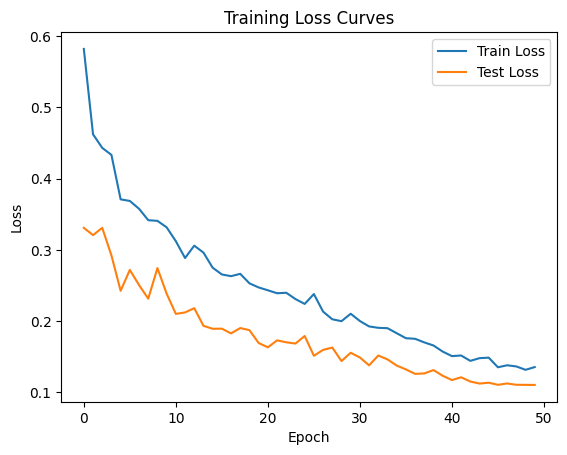

In [ ]:
# Graph the Training and Test Loss Curves
plt.plot(training_log["train_losses"])
plt.plot(training_log["test_losses"])
plt.title("Training Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.show()

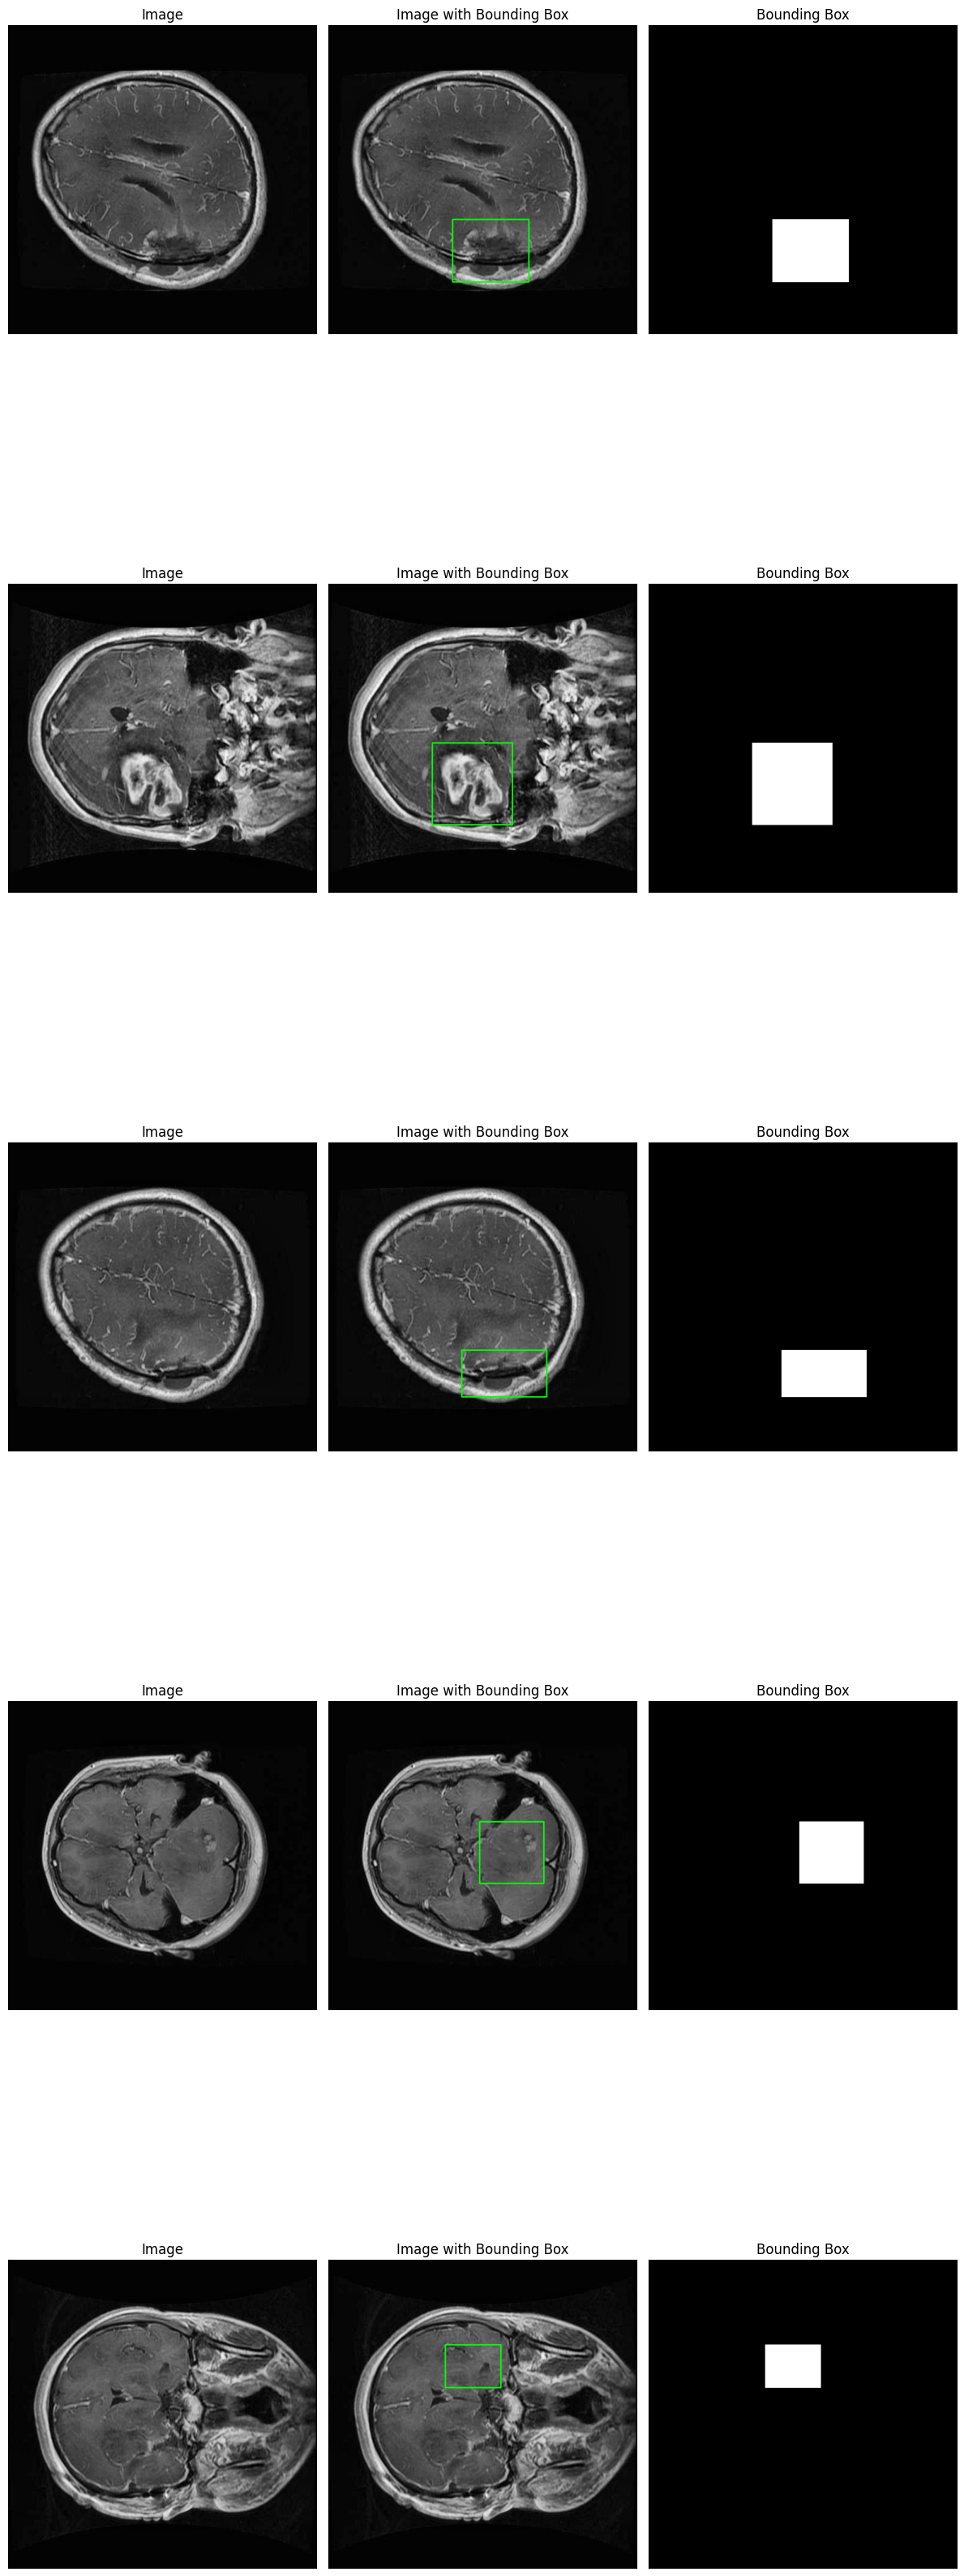

In [ ]:
# Visualize 5 Random Images from the Dataset and the Bounding Box
def visualize_random_images(n=5):
  indices = np.random.randint(0, len(train_annotation['images']), size=n)

  images =[train_annotation['images'][i] for i in indices ]

  annotations = [train_annotation['annotations'][i] for i in indices ]
  j=1
  plt.figure(figsize=(12, 4 * 2 * n))
  for img,ann in zip(images,annotations):
    plt.subplot(n,3,j)
    j+=1
    image = cv2.imread(train_folder + img['file_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image")
    segmentation = ann['segmentation']
    segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)

    cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

    plt.subplot(n,3,j)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image with Bounding Box")
    j+=1
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    cv2.fillPoly(mask, [segmentation], color=1)
    plt.subplot(n,3,j)

    plt.imshow(mask,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Bounding Box")
    plt.tight_layout()
    j+=1

visualize_random_images()

In [ ]:
# Find the Prediction for a Specific Image and Return the Tensor
def predict(image_path, model, threshold=0.5, device="cpu"):
    model = model.to(device)
    # Read and preprocess the image
    image = Image.open(image_path)

    # Resize the image to match model's expected sizing
    resized_image = image.resize((256, 256))


    # Preprocess input (normalize to [0, 1] range)
    to_tensor = transforms.ToTensor()
    input_image = to_tensor(resized_image)
    ### Normalize Image ###
    normalizing_transform = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    input_image = normalizing_transform(input_image)
    # Perform prediction
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():

      pred_mask = model.forward(input_image.to(device))

    # Apply threshold to prediction mask
    pred_mask = torch.sigmoid(pred_mask)
    pred_mask[pred_mask >= threshold] = 1  # set values >= threshold to 1 (foreground)
    pred_mask[pred_mask < threshold] = 0   # set values < threshold to 0 (background)
    # reduce the dimensions down to 2
    pred_mask = np.squeeze(pred_mask, axis=0)
    pred_mask = np.squeeze(pred_mask, axis=0)
    # Count number of pixels where mask is 1 (foreground)
    num_pixels = np.count_nonzero(pred_mask)
    return pred_mask

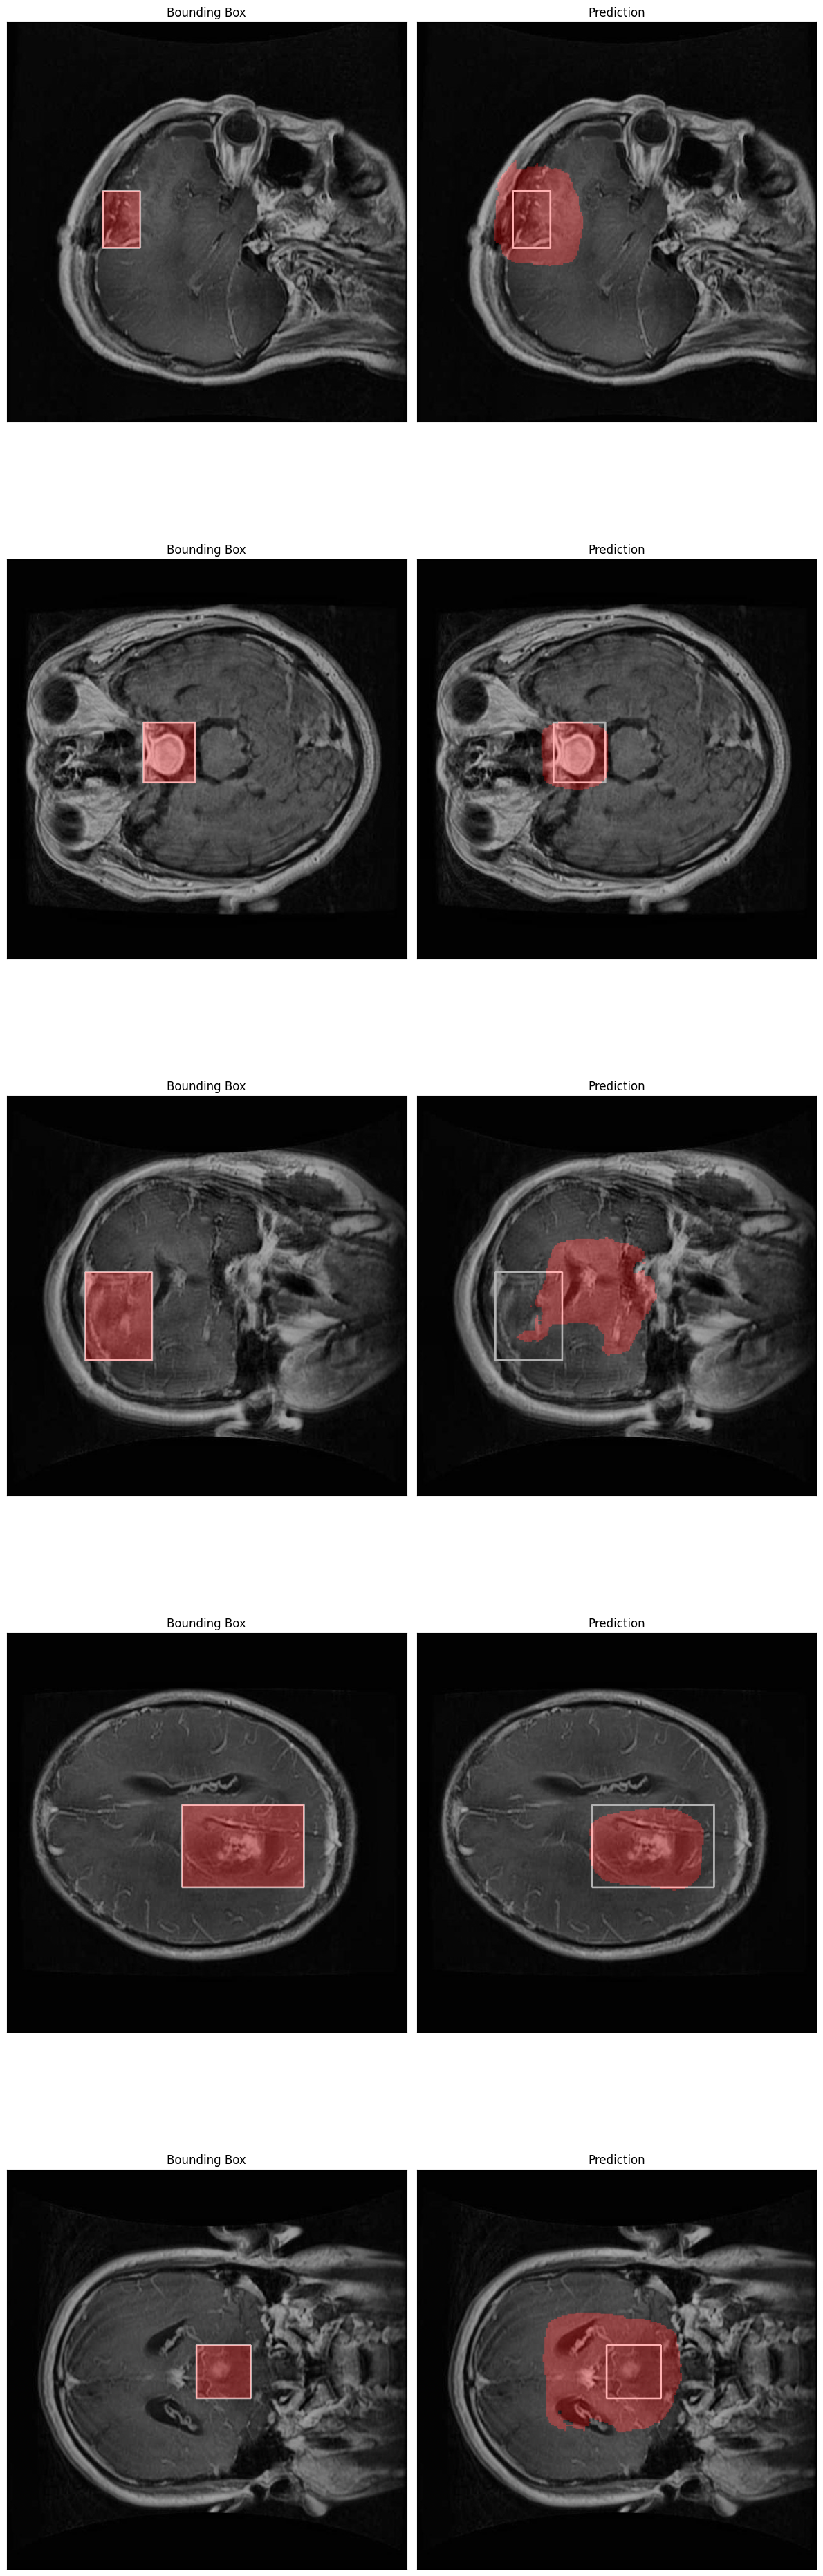

In [ ]:
# Visualize 5 Random Images with their Bounding Boxes and Predicted Masks
from skimage import color
def test_random_images_mask(n=5):
  # select n random images
  # use cv and plt to show these images

    indices = np.random.randint(0, len(test_annotation['images']), size=n)

    images =[test_annotation['images'][i] for i in indices ]

    annotations = [test_annotation['annotations'][i] for i in indices ]
    j=1
    plt.figure(figsize=(12, 4 * 2 * n))
    counter = 0
    for img,ann in zip(images,annotations):
        plt.subplot(n,2,j)
        image = cv2.imread(test_folder + img['file_name'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation = ann['segmentation']
        segmentation = np.array(segmentation[0], dtype=np.int32).reshape(-1, 2)

        cv2.polylines(image, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)
        plt.subplot(n,2,j)





        box = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        cv2.fillPoly(box, [segmentation], color=1)
        annot_color = color.label2rgb(box,np.array(image))

        plt.imshow(annot_color)
        plt.xticks([])
        plt.yticks([])
        plt.title("Ground Truth")
        plt.tight_layout()
        j+=1

        mask = predict(test_folder + img['file_name'], model)

        plt.subplot(n,2,j)
        mask = mask.unsqueeze(0).unsqueeze(0)

        mask = F.interpolate(mask, size=(image.shape[0], image.shape[1]), mode='bilinear', align_corners=False)

        mask = mask.squeeze(0).squeeze(0)


        result_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        result_image[mask == 1] = 255
        pred_color = color.label2rgb(result_image,np.array(image))

        plt.xticks([])
        plt.yticks([])
        plt.subplot(n,2,j)
        j+=1
        plt.imshow(pred_color)
        plt.title("Prediction")
        counter+=1
        if counter >= 5:
          break
test_random_images_mask()

In [ ]:
# IoU Calculation Function
def calculate_iou(pred_mask, true_mask, class_id):

    pred_mask = np.asarray(pred_mask, dtype=np.bool_)
    true_mask = np.asarray(true_mask, dtype=np.bool_)
    intersection = 0
    union = 0
    # Calculate intersection over Union
    for x, y in zip(pred_mask, true_mask):
        for a, b in zip(x, y):
            if a & b:
              intersection += 1
              union += 1
            elif a | b:
              union += 1

    # Return it
    iou = intersection / union
    return iou


images =test_annotation['images']

annotations = test_annotation['annotations']


def iou_all(test_annotation, test_folder, model):
    images = test_annotation['images']
    annotations = test_annotation['annotations']

    iou_total = 0
    total_images = len(images)
    counter = 0
    for img, ann in zip(images, annotations):
        image = cv2.imread(test_folder + img['file_name'])  # Load the image
        segmentation = ann['segmentation']  # Get the segmentation polygon from the annotation

        # Predict the mask using the model
        mask = predict(test_folder + img['file_name'], model)

        # Create a blank box mask with the same size as the image
        box = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        y1 = segmentation[0][1]
        x1 = segmentation[0][0]
        y2 = segmentation[0][5]
        x2 = segmentation[0][4]
        box[int(y1):int(y2), int(x2):int(x1)] = 1
        # Convert mask to tensor if it's not already
        mask = mask.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

        # Resize the predicted mask to match the image size
        mask = F.interpolate(mask, size=(image.shape[0], image.shape[1]), mode='bilinear', align_corners=False)

        # Squeeze to remove extra dimensions
        mask = mask.squeeze(0).squeeze(0)
        mask = mask.cpu().numpy()
        threshold = 0.5
        mask = (mask >= threshold).astype(np.uint8)
        counter += 1

        # Calculate IoU for this image
        iou_score = calculate_iou(mask, box, 1)
        iou_total += iou_score  # Accumulate the IoU score

    # Calculate average IoU for all images
    average_iou = iou_total / total_images
    return average_iou

iou = iou_all(test_annotation, test_folder, model)
print(iou)

0.5532568804086047
